Fix the seeds

In [1]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [2]:
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel measurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  False 



Here are the functions, which create measurements vectror for all patterns in Hadamard basis

In [3]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [4]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel measurements and their class labels

In [5]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MeasurementsDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        
        self.labels = mnist.targets
        images = mnist.data
        
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize((px, px))])

        images = transform(images)
        self.target_images = (images - images.min()) / (images.max() - images.min())

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.labels[indx]

    def __len__(self):
        return len(self.measurements)

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MeasurementsDataset(MNIST(root='./data', train=True, download=True))
test_set = MeasurementsDataset(MNIST(root='./data', train=False, download=True))

batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [7]:
variance = np.array([])
for i in range(px ** 2):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

# Training

Class for drawing plots

In [8]:
from collections import defaultdict
import matplotlib.pyplot as plt

class ProgressPlotter:
    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
        if len(data) > 1:
            ax.legend(loc="best")
        if history_len < 20:
            ax.set_xlabel("step")
            ax.set_xticks(np.arange(history_len))
            ax.set_xticklabels(np.arange(history_len))

    """
     groups list of keys like [['loss_train','loss_val'],['accuracy']]
     All charts within a group will be plot in the same axis
  """

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(24 // n_groups, 5))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Training staff

In [9]:
def calculate_accuracy(pred_l, real_l):
    correct, total = 0, 0
    _, predicted = torch.max(pred_l.data, 1) # get predicted class
    total += real_l.size(0) # all examples
    correct += (predicted == real_l.to(device)).sum().item() # correct predictions
    return correct / total

In [10]:
def train(model, criterion, optimizer, most_important, train_loader, test_loader,
          num_epochs=6, pp=None):

    if pp is None:
        pp = ProgressPlotter(groups=['loss', 'accuracy'])

    for epoch in range(num_epochs):

        train_loss, train_acc = 0, 0
        model.train()
        for batch in train_loader:
            measurements, labels = batch
            measurements, labels = measurements.to(device), labels.to(device)

            optimizer.zero_grad()
            x = measurements[:, most_important].to(device)
            pred = model(x)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += calculate_accuracy(pred, labels)

        test_loss, test_acc = 0, 0
        model.eval()
        for batch in test_loader:
            measurements, labels = batch
            measurements, labels = measurements.to(device), labels.to(device)

            x = measurements[:, most_important].to(device)
            pred = model(x)

            loss = criterion(pred, labels)

            test_loss += loss.item()
            acc = calculate_accuracy(pred, labels)
            test_acc += acc

        pp.add_scalar('loss', train_loss / len(train_loader), 'train')
        pp.add_scalar('accuracy', train_acc / len(train_loader), 'train')

        pp.add_scalar('loss', test_loss / len(test_loader), 'test')
        pp.add_scalar('accuracy', test_acc / len(test_loader), 'test')

        pp.display()

    return pp

Model

In [11]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_length, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

Training with differet input layer size (number of measurements): 1024, 800, 500, 200, 100, 64, 40, 20, 10, 5, 1

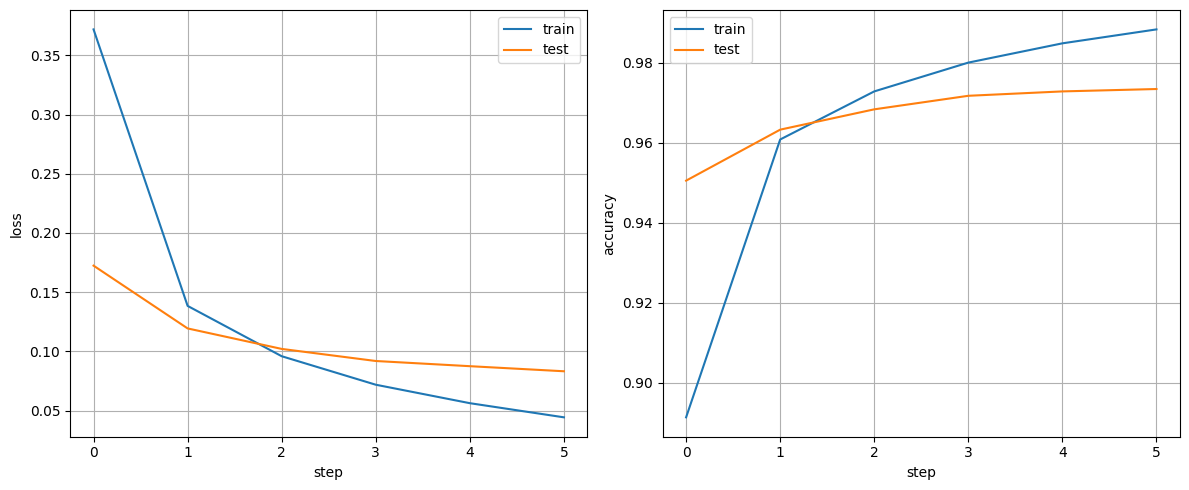

CPU times: total: 2min 51s
Wall time: 11.6 s


In [12]:
%%time

most_important = np.argsort(variance)[-1024:]

model = Net(1024).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp1024 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [13]:
acc_1024 = pp1024.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 1024: {acc_1024}")

Accuracy 1024: 0.9734275477707006


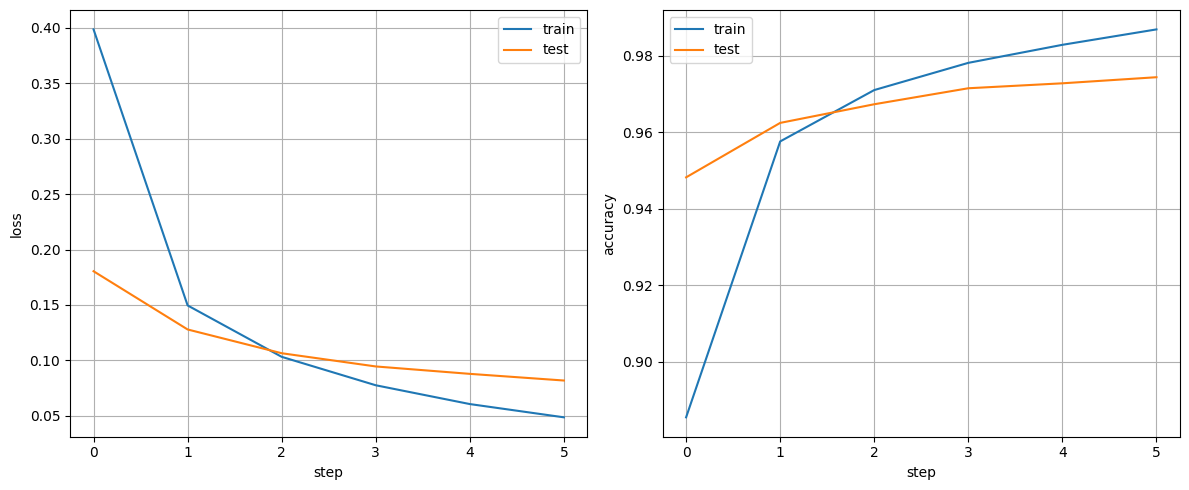

CPU times: total: 2min 41s
Wall time: 10.9 s


In [14]:
%%time

most_important = np.argsort(variance)[-800:]

model = Net(800).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp800 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [15]:
acc_800 = pp800.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 800: {acc_800}")

Accuracy 800: 0.974422770700637


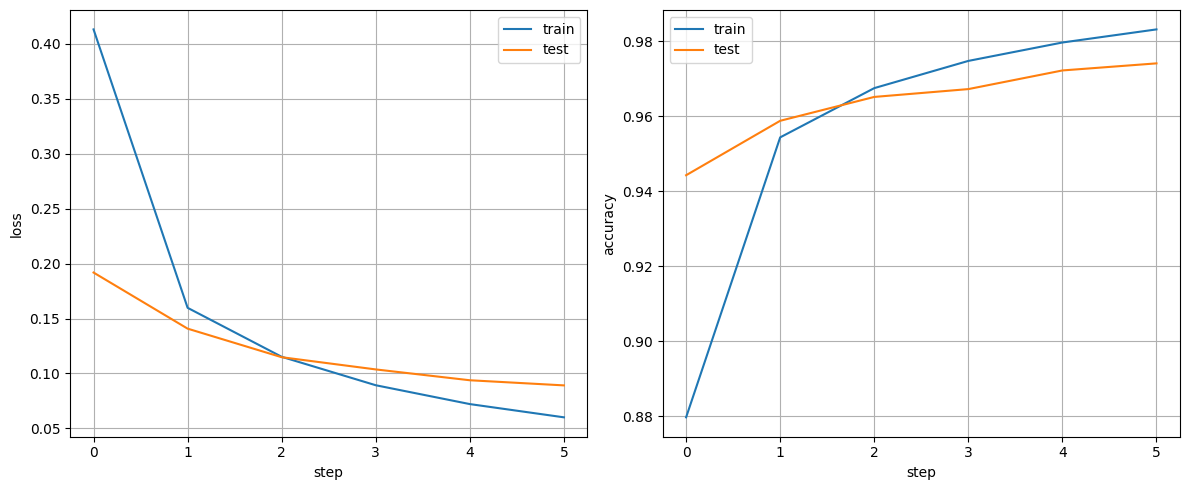

CPU times: total: 2min 44s
Wall time: 11.3 s


In [16]:
%%time

most_important = np.argsort(variance)[-500:]

model = Net(500).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp500 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [17]:
acc_500 = pp500.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 500: {acc_500}")

Accuracy 500: 0.9741242038216561


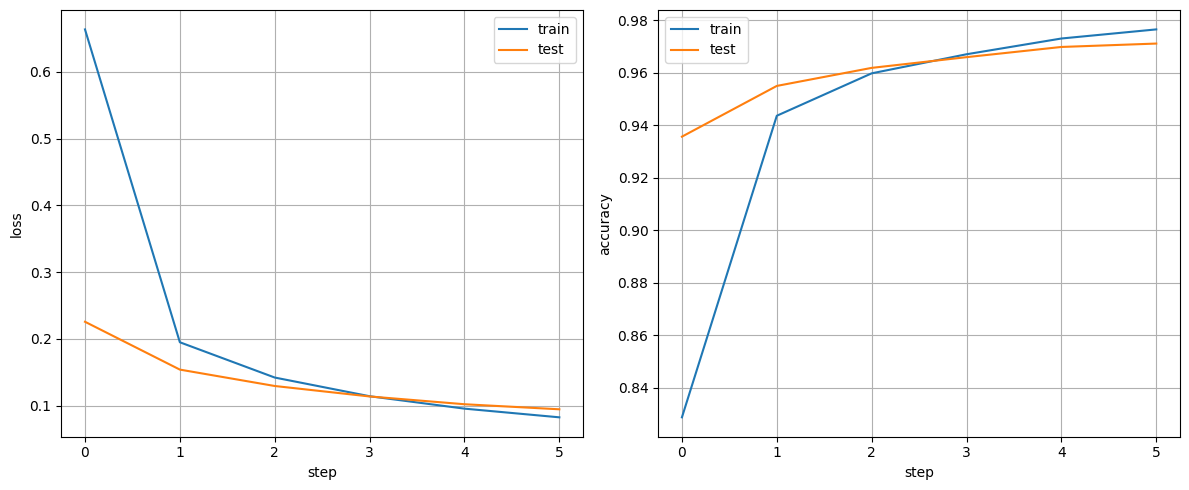

CPU times: total: 2min 33s
Wall time: 10.4 s


In [18]:
%%time

most_important = np.argsort(variance)[-200:]

model = Net(200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp200 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [19]:
acc_200 = pp200.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 200: {acc_200}")

Accuracy 200: 0.9710390127388535


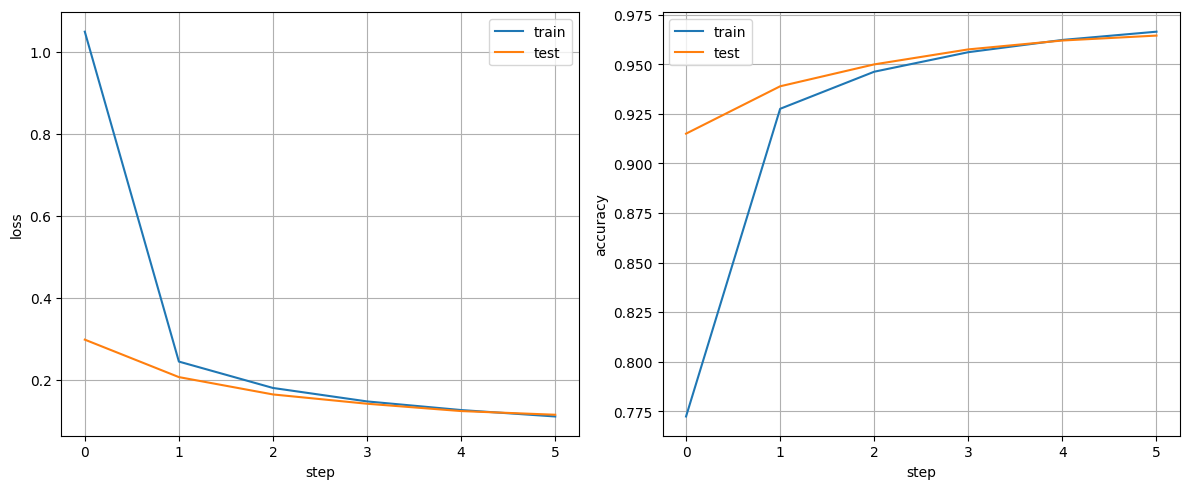

CPU times: total: 2min 21s
Wall time: 9.66 s


In [20]:
%%time

most_important = np.argsort(variance)[-100:]

model = Net(100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp100 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [21]:
acc_100 = pp100.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 100: {acc_100}")

Accuracy 100: 0.9644705414012739


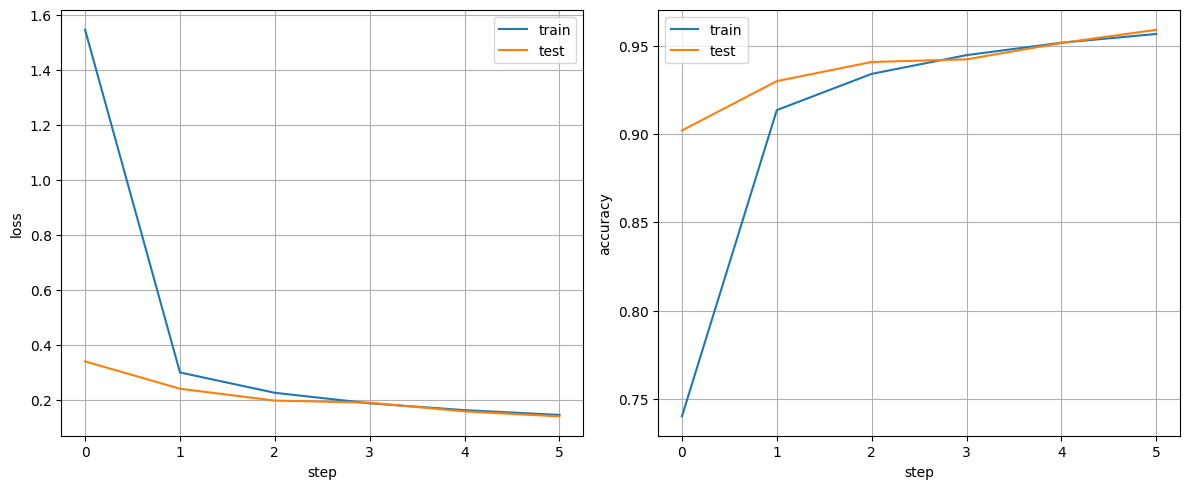

CPU times: total: 2min 16s
Wall time: 9.26 s


In [22]:
%%time

most_important = np.argsort(variance)[-64:]

model = Net(64).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp64 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [23]:
acc_64 = pp64.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 64: {acc_64}")

Accuracy 64: 0.9589968152866242


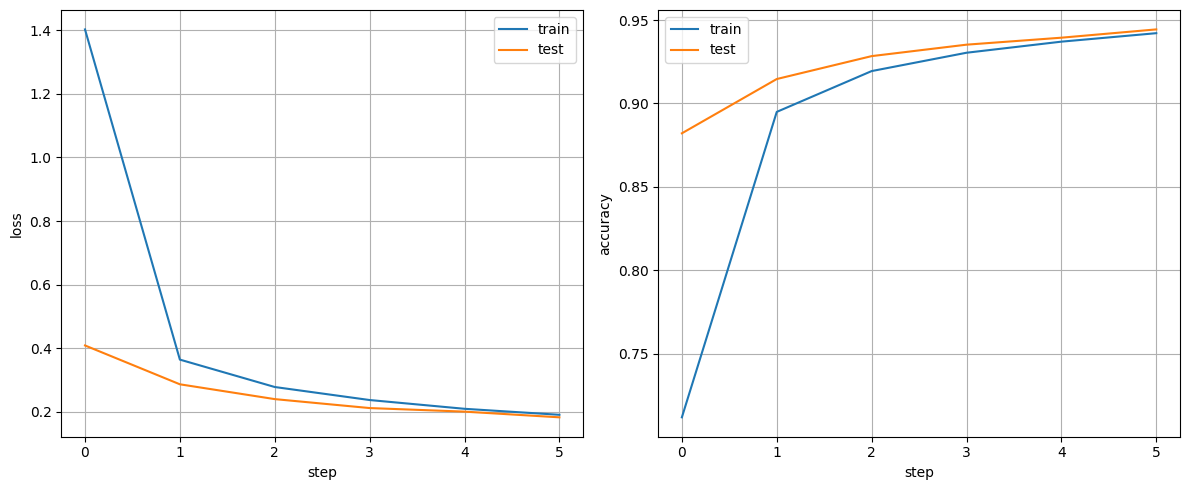

CPU times: total: 2min 14s
Wall time: 9.17 s


In [24]:
%%time

most_important = np.argsort(variance)[-40:]

model = Net(40).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp40 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [25]:
acc_40 = pp40.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 40: {acc_40}")

Accuracy 40: 0.9443670382165605


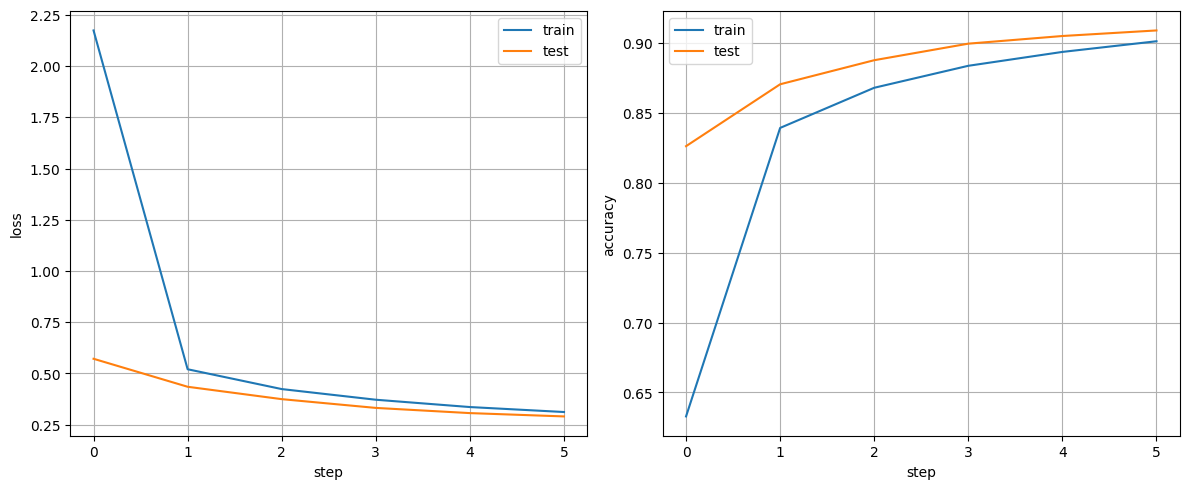

CPU times: total: 1min
Wall time: 7.65 s


In [26]:
%%time

most_important = np.argsort(variance)[-20:]

model = Net(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp20 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [27]:
acc_20 = pp20.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 20: {acc_20}")

Accuracy 20: 0.9090366242038217


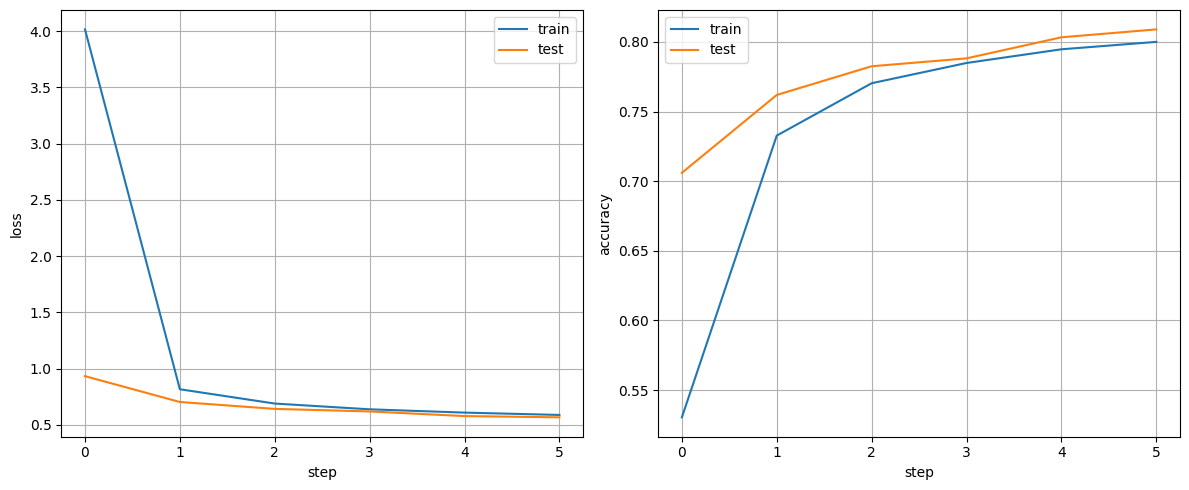

CPU times: total: 59.5 s
Wall time: 7.62 s


In [28]:
%%time

most_important = np.argsort(variance)[-10:]

model = Net(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp10 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [29]:
acc_10 = pp10.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 10: {acc_10}")

Accuracy 10: 0.8090167197452229


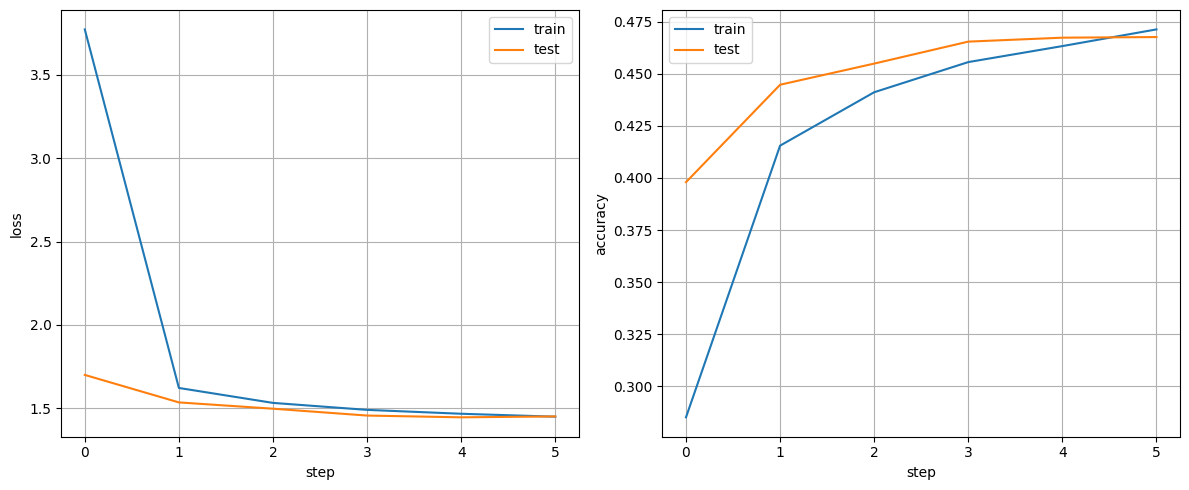

CPU times: total: 58 s
Wall time: 7.33 s


In [30]:
%%time

most_important = np.argsort(variance)[-5:]

model = Net(5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp5 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [31]:
acc_5 = pp5.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 5: {acc_5}")

Accuracy 5: 0.46765525477707004


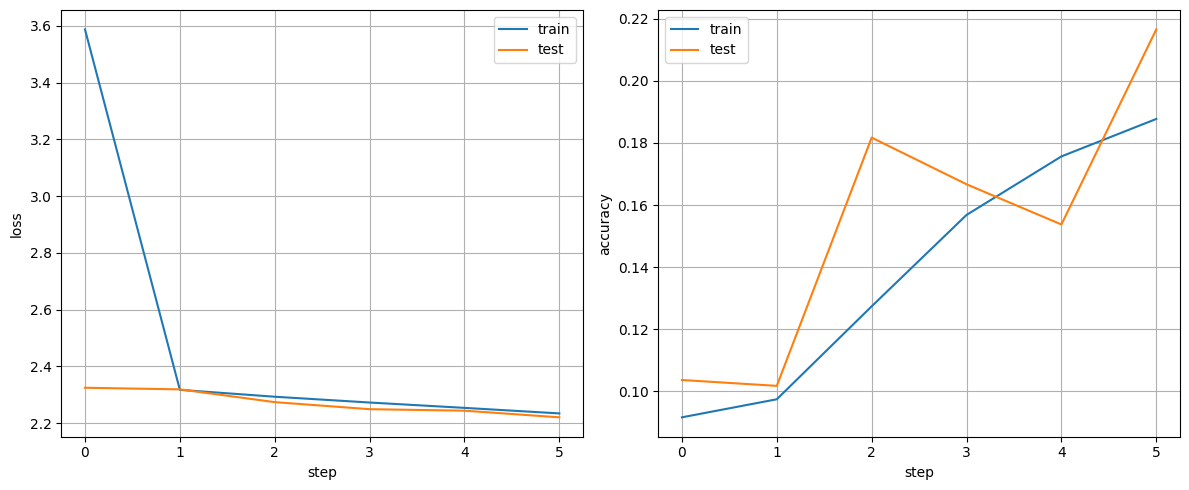

CPU times: total: 55.9 s
Wall time: 7.15 s


In [32]:
%%time

most_important = np.argsort(variance)[-1:]

model = Net(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

pp1 = train(model, criterion, optimizer, most_important, train_loader, test_loader)

In [33]:
acc_1 = pp1.history_dict["accuracy"]["test"][-1]
print(f"Accuracy 1: {acc_1}")

Accuracy 1: 0.21656050955414013


In [34]:
print(pp64.history_dict["loss"]["train"])

[1.5458067947947014, 0.29990958193265427, 0.22601751024439645, 0.18774183113366238, 0.1629896333167103, 0.14553810071362966]


In [35]:
print(pp64.history_dict["loss"]["test"])

[0.34024665838071877, 0.24079562482501196, 0.19773503794530584, 0.19002192532999596, 0.1583337978961148, 0.14025664092842371]


In [36]:
print(pp64.history_dict["accuracy"]["train"])

[0.740055303837953, 0.9135127931769723, 0.9340518390191898, 0.9446628464818764, 0.9516924307036247, 0.9566564498933902]


In [37]:
print(pp64.history_dict["accuracy"]["train"])

[0.740055303837953, 0.9135127931769723, 0.9340518390191898, 0.9446628464818764, 0.9516924307036247, 0.9566564498933902]
